## Assignment 7: Wrangling data from APIs

The previous assignment gave you some experience with the data wrangling functionality of `pandas`; this are skills you'll be returning to throughout the semester.  In this assignment, you'll be expanding upon those skills by working with data from the City of Fort Worth's Open Data API.  As you learned in class, data APIs are interfaces that allow you to access data programmatically.  In turn, data APIs allow data to be accessed by applications such as websites, or in this case a data analysis pipeline.  

Fort Worth's Open Data API is powered by [Socrata](http://www.socrata.com/), a start-up that helps cities open up their data catalogs to the public.  Many other cities, including [New York City](https://nycopendata.socrata.com/) and [Dallas](https://www.dallasopendata.com/), use Socrata as well.  Fort Worth's open data catalog is small, but growing, and the city's use of Socrata makes its data available in many different ways.  

In this assignment we'll be working with Fort Worth Police crime data, available at this link: https://data.fortworthtexas.gov/Public-Safety-Courts/Crime-Data/k6ic-7kp7.  The data include observations going back more than 100 years!  However, we'll be working with more recent data as we can presume that they are more complete.  

The Socrata web interface includes a lot of options for filtering, manipulating, and visualizing the data.  As we want to be able to access it inside our data analysis environment in `pandas`, however, we'll want to be able to access it directly.  Socrata gives several options for exporting the data in a variety of formats, including CSV; however, you are going to learn in this assignment how to access the data through Socrata's open data API.  

Generally, data APIs make data available in one of two formats: JSON (**J**ava**S**cript **O**bject **N**otation) or XML (e**X**tensible **M**arkup **L**anguage).  JSON is becoming the more common of the two, as it fits well within the structure of modern websites, which rely heavily on the JavaScript programming language.  

JSON is a way of encoding data objects with JavaScript, and organizes data as a series objects represented by key-value pairs.  In terms of how you are used to thinking about data, the __object__ represents a record, the __key__ represents a column header, and the __value__ represents a data value.  Let's take a look at a single JSON record from the crime database (run the cell to display it if it doesn't show): 

In [1]:
from IPython.display import IFrame

IFrame('https://data.fortworthtexas.gov/resource/k6ic-7kp7.json?case_no=180003105', width = 700, height = 450)

The code you see above is new: I'm using the capabilities of the Jupyter Notebook to display an embedded web page.  Trust me, we haven't even scratched the surface of what the Notebook can do; it can display animated GIFs, YouTube videos, interactive charts/maps, and much more!  Here, I'm showing the contents of the URL https://data.fortworthtexas.gov/resource/k6ic-7kp7.json?case_no=63560 - click it to take a look if you want - which queries Fort Worth's open data API and returns a single record from the crime dataset.  Let's break the URL down a little bit.  

The first part, https://data.fortworthtexas.gov/resource/k6ic-7kp7.json, is the __API endpoint__.  This is the root directory of the data API; if you were to follow that link, you'd see the entire dataset in JSON format.  The second part, `?case_no=63560`, is a __filter__; the question mark signifies that I am going to query the data, and the string that follows, `case_no=63560`, specifies how the data are to be subsetted.  I've done this all in the URL of the API call!

Additionally, the Socrata API recognizes a query language they call "SoQL", which operates against the API in a similar way to how SQL (Structured Query Language) allows users to access databases.  More information is here: http://dev.socrata.com/docs/queries.html.  For example, the following query will return thefts in Fort Worth for 2019: 

In [2]:
# This is the API endpoint - the source of our data
endpoint = "https://data.fortworthtexas.gov/resource/k6ic-7kp7.json"

# Here is the first part of the SoQL query - denoting what type of offense we want
type_query = "?$where=nature_of_call='THEFT'"

# Here is the second part of the query - we are taking offenses after midnight on December 1, 
# and prior to midnight on January 1
date_query = " AND reported_date>'2019-01-01T00:00:00' AND reported_date<'2020-01-01T00:00:00' &$limit=50000"

# We then concatenate together the endpoint and the two components of the SoQL query
# to get our API call.
theft_call = endpoint + type_query + date_query

The `read_json()` function in `pandas` can then translate JSON to a nice data frame.  However, we'll first need to translate our long query to a URL-appropriate string that `pandas` can use.  Currently, our API call looks like this: 

In [3]:
theft_call

"https://data.fortworthtexas.gov/resource/k6ic-7kp7.json?$where=nature_of_call='THEFT' AND reported_date>'2019-01-01T00:00:00' AND reported_date<'2020-01-01T00:00:00' &$limit=50000"

However, as there are spaces and special characters in the query, `pandas` needs the string as it will be translated in the web browser.  Fortunately, Python has a built-in library, `urllib`, that can assist with this.  The `quote` function in the `parse` module gets this done, so let's import it and format the URL accordingly.  Note the argument supplied to the `safe` parameter, which denotes characters we don't want to convert.  Take a look at how the URL changes: 

In [4]:
from urllib.parse import quote

quote(theft_call, safe = "/:?$=<->&")

'https://data.fortworthtexas.gov/resource/k6ic-7kp7.json?$where=nature_of_call=%27THEFT%27%20AND%20reported_date>%272019-01-01T00:00:00%27%20AND%20reported_date<%272020-01-01T00:00:00%27%20&$limit=50000'

We can use this formatted URL in a `read_json` call now using `pandas`, creating a new data frame called `theft_df`.  

In [5]:
import pandas as pd

formatted_call = quote(theft_call, safe = "/:?$=<->&")

theft_df = pd.read_json(formatted_call)

theft_df.shape

(11633, 17)

Our API call has returned 11632 theft calls in Fort Worth in 2019.  Let's take a quick peek at the data: 

In [6]:
theft_df.head()

,case_no_offense,case_no,reported_date,nature_of_call,from_date,offense,offense_desc,block_address,city,state,beat,division,councildistrict,attempt_complete,location_type,locationtypedescription,location_1
0,190000007-23B,190000007,2019-01-01T01:15:00.000,THEFT,2018-12-31T23:00:00.000,23B,PC 31.03 (E) (4)(B) Theft from Person 23B PURS...,2500 RODEO PLZ,FORT WORTH,TX,C11,Northwest,2.0,C,3.0,03 BAR/NIGHT CLUB,"{'latitude': '32.7901994394112', 'longitude': ..."
1,190000038-23C,190000038,2019-01-01T03:12:00.000,THEFT,2019-01-01T03:10:00.000,23C,PC 31.03 Theft - Shoplifting 23C SHOPLIFTING 23C,5900 CROMWELL MARINE CREEK RD,FORT WORTH,TX,D15,Northwest,2.0,C,7.0,07 CONVENIENCE STORE,"{'latitude': '32.85229787039639', 'longitude':..."
2,190000094-23H,190000094,2019-01-01T04:01:56.000,THEFT,2019-01-01T04:01:56.000,23H,PC 31.03(E)(3) 2015 Theft prop>=$750<$2500 23...,2700 BRYAN AVE,FORT WORTH,TX,B16,Central,9.0,C,20.0,20 RESIDENCE/HOME,"{'latitude': '32.71288719925991', 'longitude':..."
3,190000086-23H,190000086,2019-01-01T07:18:00.000,THEFT,2018-12-31T21:00:00.000,23H,PC 31.03 - Others Theft - Others 23H ALL OTHER...,8600 VANDERBILT LN,FORT WORTH,TX,H15,East,5.0,C,20.0,20 RESIDENCE/HOME,"{'latitude': '32.75935727949581', 'longitude':..."
4,190000109-240,190000109,2019-01-01T09:44:01.000,THEFT,2019-01-01T09:44:01.000,240,PC 31.03 - AUTO Auto Theft 240 MOTOR VEHICLE T...,900 W ROSEDALE ST,FORT WORTH,TX,B11,Central,9.0,C,7.0,07 CONVENIENCE STORE,"{'latitude': '32.73324537143886', 'longitude':..."


Notice how `pandas` has translated the JSON into a data frame with columns that make sense to us.  There is a lot we can do with the data here!  We have information about the date of the crime; the location - including lat/long coordinates, that need some additional parsing - the police beat, and the city council district.  Using the methods we've learned to this point, we can do some basic analysis of the data.  For example: how did theft vary by city council district in 2019?  

In [7]:
theft_by_district = theft_df.groupby('councildistrict')

theft_by_district.size()

councildistrict
2.0     925
3.0    1152
4.0    1149
5.0    1251
6.0    1194
7.0     747
8.0    1543
9.0    1497
dtype: int64

Looks like District 8 had the most thefts, followed by District 9.  Let's try plotting this with `seaborn`: 

<AxesSubplot:xlabel='count', ylabel='councildistrict'>

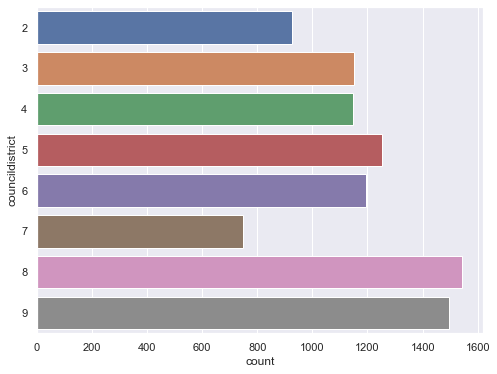

In [8]:
import seaborn as sns
sns.set(style = "darkgrid", rc = {"figure.figsize": (8, 6)})

sns.countplot(data = theft_df, y = 'councildistrict', order = range(2, 10))

A trained observer, however, would notice that that data are not normalized for population.  As data analysts, always be mindful of whether your analysis accurately represents the underlying variation in your data.  Data can easily mislead if not presented correctly; for example, while the largest cities in the United States will usually have the most crimes, they won't necessarily have the highest crime __rates__.  

However, we don't have city council district population in our dataset; in turn, we'll need to fetch it from somewhere else and __merge__ it to our existing data.  As we discussed in class, merges are based on __key fields__ that match between two different tables.  Also, recall from class our discussion of the four types of merges available to you in `pandas` via the `.merge()` method, which can be passed as arguments to the `how` parameter: 

* `'inner'` (the default): only the matching rows are retained
* `'left'`: all rows from the first table are retained; only matching rows from the second table are retained
* `'right'`: all rows from the second table are retained; only matching rows from the first table are retained
* `'outer'`: all rows are retained, regardless of a match between the two tables

We'll be conducting a very simple merge here, in which all rows will match between the two tables.  Let's read in the city council population data from my website:  

In [9]:
council = pd.read_csv('http://personal.tcu.edu/kylewalker/data/cd_population.csv')

council

,name,total,district
0,2 - Carlos Flores,107649,2
1,3 - Brian Byrd,98711,3
2,4 - Cary Moon,112074,4
3,5 - Gyna Bivens,104732,5
4,6 - Jungus Jordan,98986,6
5,7 - Dennis Shingleton,124235,7
6,8 - Kelly Allen Gray,103432,8
7,9 - Ann Zadeh,95479,9


We can now create a data frame from our `groupby` result (resetting the index, as `pandas` places the group name in the index), to get it ready for a merge.  

In [10]:
theft_by_district_df = pd.DataFrame(theft_by_district.size().reset_index())

theft_by_district_df.columns = ['district', 'count']

theft_by_district_df

,district,count
0,2.0,925
1,3.0,1152
2,4.0,1149
3,5.0,1251
4,6.0,1194
5,7.0,747
6,8.0,1543
7,9.0,1497


We'll be able to merge on the "district" column, which I've renamed in the second data frame for clarity.  First, let's check our `dtypes` to make sure they match up: 

In [11]:
council.dtypes

name        object
total        int64
district     int64
dtype: object

In [12]:
theft_by_district_df.dtypes

district    float64
count         int64
dtype: object

Now, we can do the merge with the `.merge()` method in `pandas`.  

In [13]:
council_merged = council.merge(theft_by_district_df, on = 'district', how = "left")

council_merged

,name,total,district,count
0,2 - Carlos Flores,107649,2,925
1,3 - Brian Byrd,98711,3,1152
2,4 - Cary Moon,112074,4,1149
3,5 - Gyna Bivens,104732,5,1251
4,6 - Jungus Jordan,98986,6,1194
5,7 - Dennis Shingleton,124235,7,747
6,8 - Kelly Allen Gray,103432,8,1543
7,9 - Ann Zadeh,95479,9,1497


Perfect!  We can now calculate a new column that measures rate per 1000 residents for thefts in 2019.

In [14]:
council_merged['rate'] = (council_merged['count'] / council_merged['total']) * 1000

council_merged

,name,total,district,count,rate
0,2 - Carlos Flores,107649,2,925,8.592741
1,3 - Brian Byrd,98711,3,1152,11.670432
2,4 - Cary Moon,112074,4,1149,10.252155
3,5 - Gyna Bivens,104732,5,1251,11.944773
4,6 - Jungus Jordan,98986,6,1194,12.062312
5,7 - Dennis Shingleton,124235,7,747,6.012798
6,8 - Kelly Allen Gray,103432,8,1543,14.918014
7,9 - Ann Zadeh,95479,9,1497,15.678840


And we can plot the results: 

<AxesSubplot:xlabel='rate', ylabel='name'>

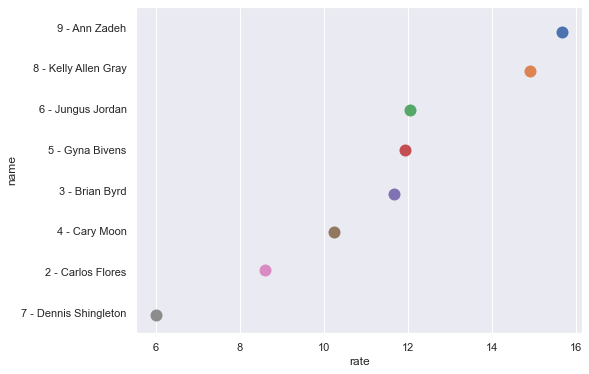

In [15]:
council_sort = council_merged.sort_values('rate', ascending = False)

sns.stripplot(data = council_sort, x = 'rate', y = 'name', size = 12)

Just in case you were wondering: TCU is split across council districts 3 and 9.  

The last thing we're going to do is look at how thefts varied by date in 2019.  We have two columns that represent dates: `from_date` and `reported_date`; however they are not currently formatted as dates.  Dates are very tricky types to work with in data analysis - there are many different ways that dates can be written!  Fortunately, ours are currently fairly consistent - we just need to do a little work with them.  

The date fields in our data frame include a substring, `'T00:00:00'`; this means that the Socrata date field type supports time of day, but we don't have this information in our dataset.  As such, we're going to remove it from the string.  

The steps below will do the following: 

* Remove the unnecessary time information, creating a new column `d1`; 
* Create a new column formatted as a date, `date2`, from `date1`, using the `to_datetime()` function in `pandas`.  

In [16]:
theft_df['date1'] = theft_df['reported_date'].str[:10]

theft_df['date2'] = pd.to_datetime(theft_df['date1'])

theft_df.head()

,case_no_offense,case_no,reported_date,nature_of_call,from_date,offense,offense_desc,block_address,city,state,beat,division,councildistrict,attempt_complete,location_type,locationtypedescription,location_1,date1,date2
0,190000007-23B,190000007,2019-01-01T01:15:00.000,THEFT,2018-12-31T23:00:00.000,23B,PC 31.03 (E) (4)(B) Theft from Person 23B PURS...,2500 RODEO PLZ,FORT WORTH,TX,C11,Northwest,2.0,C,3.0,03 BAR/NIGHT CLUB,"{'latitude': '32.7901994394112', 'longitude': ...",2019-01-01,2019-01-01
1,190000038-23C,190000038,2019-01-01T03:12:00.000,THEFT,2019-01-01T03:10:00.000,23C,PC 31.03 Theft - Shoplifting 23C SHOPLIFTING 23C,5900 CROMWELL MARINE CREEK RD,FORT WORTH,TX,D15,Northwest,2.0,C,7.0,07 CONVENIENCE STORE,"{'latitude': '32.85229787039639', 'longitude':...",2019-01-01,2019-01-01
2,190000094-23H,190000094,2019-01-01T04:01:56.000,THEFT,2019-01-01T04:01:56.000,23H,PC 31.03(E)(3) 2015 Theft prop>=$750<$2500 23...,2700 BRYAN AVE,FORT WORTH,TX,B16,Central,9.0,C,20.0,20 RESIDENCE/HOME,"{'latitude': '32.71288719925991', 'longitude':...",2019-01-01,2019-01-01
3,190000086-23H,190000086,2019-01-01T07:18:00.000,THEFT,2018-12-31T21:00:00.000,23H,PC 31.03 - Others Theft - Others 23H ALL OTHER...,8600 VANDERBILT LN,FORT WORTH,TX,H15,East,5.0,C,20.0,20 RESIDENCE/HOME,"{'latitude': '32.75935727949581', 'longitude':...",2019-01-01,2019-01-01
4,190000109-240,190000109,2019-01-01T09:44:01.000,THEFT,2019-01-01T09:44:01.000,240,PC 31.03 - AUTO Auto Theft 240 MOTOR VEHICLE T...,900 W ROSEDALE ST,FORT WORTH,TX,B11,Central,9.0,C,7.0,07 CONVENIENCE STORE,"{'latitude': '32.73324537143886', 'longitude':...",2019-01-01,2019-01-01


Scroll to the end; we see that `date1` and `date2` look similar; however, `date2` is formatted as a date, which means that `pandas` recognizes how to work with it in sequence.  In turn, we can plot how burglaries varied by day in Fort Worth last December: 

<AxesSubplot:xlabel='Date', ylabel='Number'>

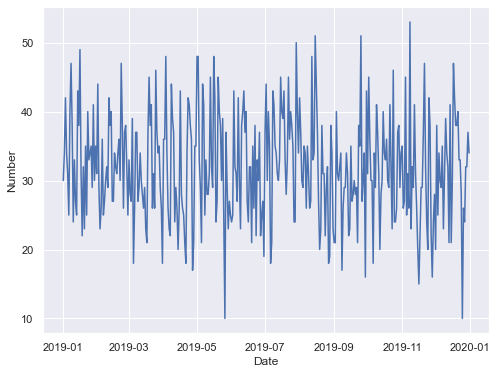

In [17]:
theft_by_date = (theft_df
                .groupby('date2')
                .size()
                .reset_index()
                )

theft_by_date.columns = ["Date", "Number"]


sns.lineplot(x = "Date", y = "Number", data = theft_by_date)

Read through the code to understand what it does.  I'm introducing you here to a new process of operations called _method chaining_ which is very popular in data programming. Rather than writing out a separate command for each method, generating new objects along the way, e.g.:

```python
theft_groupby = theft_df.groupby('date2')
theft_size = theft_groupby.size()
theft_reset = theft_size.reset_index()
```

Method chaining allows for the specification of a data wrangling process as a series of steps.  The code we use - 

```python
theft_by_date = (theft_df
                .groupby('date2')
                .size()
                .reset_index()
                )
```

can be read as "To generate the object `theft_by_date`, we first take the `theft_df` data frame, then we group it by the `"date2"` column, then we compute the size, then we reset the index."  Method chains over multiple lines like these must be wrapped in parentheses so Python knows that the methods belong to a multi-line chain.  This is the style that I often use in my projects as it helps me keep my thoughts organized.  

Once we've generated an appropriate object using the method chain, we can give it sensible column names and plot the result with `sns.lineplot()`.

One thing you may notice with the plot, however, is that it appears choppy, making it difficult to discern trends for the entire year.  An alternative way to visualize this is by re-calculating the data as a _rolling mean_, where the number associated with each date represents an average of the days around it.  __pandas__ is designed specifically for this type of time-series analysis.  

In [18]:
theft_by_date['Weekly_Avg'] = theft_by_date['Number'].rolling(window = 7, min_periods = 1).mean()

theft_by_date.head()

,Date,Number,Weekly_Avg
0,2019-01-01,30,30.000000
1,2019-01-02,34,32.000000
2,2019-01-03,42,35.333333
3,2019-01-04,34,35.000000
4,2019-01-05,31,34.200000


Above, we use the `.rolling()` method to specify a "window" of observations around each row for a given column.  We can then compute a statistic (e.g. sum, mean) over that rolling window and we get back the appropriate result.  The `min_periods` argument is necessary here as the default will return `NaN` (missing data) for rows with fewer observations in their windows than the specified size.

As we've now computed the seven-day average for theft in 2019 by day, we can visualize it on a chart.

<AxesSubplot:xlabel='Date', ylabel='Weekly_Avg'>

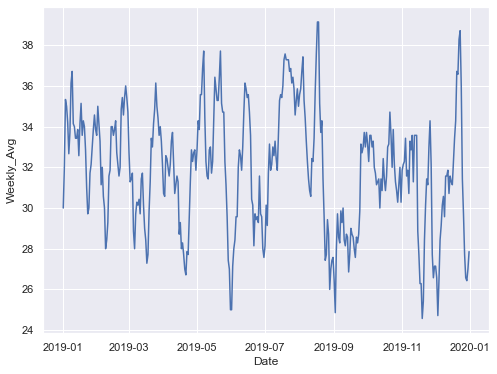

In [19]:
sns.lineplot(x = "Date", y = "Weekly_Avg", data = theft_by_date)

## Exercises

Data APIs are complicated topics and we're only scratching the surface here of what you can do with them.  In turn, your exercises for this assignment will be a little different.  

Your job here is to replicate the above analysis for __another type of offense__ and __optionally another time period__ in Fort Worth.  Visit the Fort Worth dataset on the web here: https://data.fortworthtexas.gov/Public-Safety/Crime-Data/k6ic-7kp7/data and look at the "Nature of Call" column to see what other options there are.  Some tips: some crimes like murder are relatively rare, so you might be better served choosing an offense that is more frequent.  Also, values in the "Description" column have changed somewhat over time, so be mindful of this when selecting a type of crime.  

What this basically involves is re-using the code I've already written for this assignment, and modifying it slightly for your chosen type of offense and your chosen time period.  To do this, you'll modify the API call at the beginning of the code accordingly.  I want you to get a sense of how you can "change parameters" in an API call, and in turn get different results.  Indeed, an enterprising analysis like this could wrap everything in a function and re-produce analyses by parameterizing these inputs in Python; you don't have to do that here, but hopefully this gives you a sense of why it is useful to write everything out with code.  

To get full credit for this assignment, your results should include responses to the following questions:  

1. How did crime incidents for your chosen offense in your chosen time period vary by city council district?  
2. Draw a chart that shows these variations.  
3. How did crime rates per 1000 residents in your chosen time period vary by city council district for your chosen offense?  
4. Draw a chart that shows variations in rates by council district.  
5. Draw a line chart that shows how incidents of your chosen offense varied by day in the time period that you chose.  